In [1]:
# Clone the ibm/tsfm
! git clone https://github.com/IBM/tsfm.git

Cloning into 'tsfm'...
remote: Enumerating objects: 2569, done.
remote: Counting objects: 100% (1116/1116), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 2569 (delta 760), reused 802 (delta 682), pack-reused 1453 (from 1)
Receiving objects: 100% (2569/2569), 23.37 MiB | 21.67 MiB/s, done.
Resolving deltas: 100% (1505/1505), done.


In [2]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

/content/tsfm


In [3]:
# Install the tsfm library
! pip install ".[notebooks]"

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.9 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 k

In [4]:
import math
import os
import tempfile

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import TinyTimeMixerForPrediction, TrackingCallback, count_parameters, load_dataset
from tsfm_public.toolkit.visualization import plot_predictions

In [5]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [60]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Apple
ticker = "AAPL"

# Fetch the data for the year 2023 with hourly intervals
apple_stock_data = yf.download(
    ticker,
    start="2023-01-01",
    end="2023-12-31",
    interval="60m"  # 60m for hourly data
)

# Reset the index to have the timestamp as a column
apple_stock_data.reset_index(inplace=True)

# Display the first few rows to check the data
print(apple_stock_data.head())


[*********************100%***********************]  1 of 1 completed

             Datetime        Open        High         Low       Close  \
0 2023-01-03 09:30:00  130.279999  130.899994  125.230003  125.459999   
1 2023-01-03 10:30:00  125.459999  125.870003  124.730003  125.345001   
2 2023-01-03 11:30:00  125.350197  125.370003  124.349098  124.660004   
3 2023-01-03 12:30:00  124.660004  124.940002  124.190002  124.649902   
4 2023-01-03 13:30:00  124.669899  125.000000  124.190002  124.570000   

    Adj Close    Volume  
0  125.459999  27775505  
1  125.345001  18104999  
2  124.660004  11248777  
3  124.649902   8860080  
4  124.570000   8388062  


In [61]:
# Select the relevant columns and rename 'Datetime' to 'timestamp'
apple_stock_data = apple_stock_data[['Datetime', 'Close']]
apple_stock_data.rename(columns={'Datetime': 'timestamp', 'Close': 'close'}, inplace=True)

# Normalize the 'close' prices
# apple_stock_data['close'] = (apple_stock_data['close'] - apple_stock_data['close'].mean()) / apple_stock_data['close'].std()

# Save the processed data to a CSV file
apple_stock_data.to_csv('/content/apple_stock_2023_hourly.csv', index=False)

# Display the first few rows to verify the data
print(apple_stock_data.head())


            timestamp       close
0 2023-01-03 09:30:00  125.459999
1 2023-01-03 10:30:00  125.345001
2 2023-01-03 11:30:00  124.660004
3 2023-01-03 12:30:00  124.649902
4 2023-01-03 13:30:00  124.570000


In [62]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

forecast_length=96
context_length=512
target_dataset = "apple_stock_2023_hourly"
DATA_ROOT_PATH = "/content/"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

In [63]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor


In [64]:
len(apple_stock_data),

(1742,)

In [82]:
def zeroshot_eval(dataset_name, batch_size, context_length=512,scale=True, forecast_length=96, prediction_filter_length=None):

    timestamp_column = "timestamp"
    id_columns = []
    target_columns = ["close"]
    split_config = {
                      "train": [  0,
                       len(apple_stock_data),],
                "valid": [  0,
                       len(apple_stock_data),],
                    "test": [
                        0,
                       len(apple_stock_data),
                    ],
                }
    # Understanding the split config -- slides

    data = pd.read_csv(
        '/content/apple_stock_2023_hourly.csv',
        parse_dates=[timestamp_column],
    )

    column_specifiers = {
        "timestamp_column": timestamp_column,
        "id_columns": id_columns,
        "target_columns": target_columns,
        "control_columns": [],
    }
    scaler_type = "standard" if scale else None

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=scale,
        encode_categorical=False,
         scaler_type = "standard" if scale else None,
    )

    train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
        data, split_config, fewshot_fraction=1, fewshot_location="first"
    )

    print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")



    # Load model
    if prediction_filter_length is None:
        zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION
        )
    else:
        if prediction_filter_length <= forecast_length:
            zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm-granite/granite-timeseries-ttm-v1",
                revision=TTM_MODEL_REVISION,
                prediction_filter_length=prediction_filter_length,
            )
        else:
            raise ValueError("`prediction_filter_length` should be <= `forecast_length")
    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(train_dataset)
    print(zeroshot_output)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=train_dataset,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",

        channel=0,
    )

### Zero-shot

In [126]:

    timestamp_column = "timestamp"
    id_columns = []
    target_columns = ["close"]
    split_config = {
                      "train": [  0,
                       len(apple_stock_data),],
                "valid": [  0,
                       len(apple_stock_data),],
                    "test": [
                        0,
                       len(apple_stock_data),
                    ],
                }
    # Understanding the split config -- slides

    data = pd.read_csv(
        '/content/apple_stock_2023_hourly.csv',
        parse_dates=[timestamp_column],
    )

    column_specifiers = {
        "timestamp_column": timestamp_column,
        "id_columns": id_columns,
        "target_columns": target_columns,
        "control_columns": [],
    }

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        # scaling=True,
        encode_categorical=False,
        # scaler_type=None,
    )

    train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
        data, split_config, fewshot_fraction=1, fewshot_location="first"
    )

In [83]:
 zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION
        )

In [90]:
train_dataset[1]

{'past_values': tensor([[125.3450],
         [124.6600],
         [124.6499],
         [124.5700],
         [124.6200],
         [125.0500],
         [125.9983],
         [127.3800],
         [128.0650],
         [127.2601],
         [125.7250],
         [125.8300],
         [126.3800],
         [126.7700],
         [126.5599],
         [126.5032],
         [126.4800],
         [125.8887],
         [125.1600],
         [125.0200],
         [126.3750],
         [127.2450],
         [128.3299],
         [128.2500],
         [129.3350],
         [129.8100],
         [129.5200],
         [132.5650],
         [133.0850],
         [132.7450],
         [132.4950],
         [131.4950],
         [130.4500],
         [130.1900],
         [129.4100],
         [129.0300],
         [129.1200],
         [129.6599],
         [130.3612],
         [130.1500],
         [130.7500],
         [132.0200],
         [131.6850],
         [132.8000],
         [132.8000],
         [132.4050],
         [132.9218]

In [78]:
output = zeroshot_model.forward(train_dataset[0]["past_values"].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape

torch.Size([1, 96, 1])

In [79]:
output

TinyTimeMixerForPredictionOutput(loss=None, prediction_outputs=tensor([[[166.2246],
         [166.4812],
         [166.5631],
         [166.6995],
         [166.7952],
         [166.8564],
         [166.9048],
         [166.8437],
         [166.8181],
         [166.8650],
         [166.7633],
         [166.7128],
         [166.6433],
         [166.5300],
         [166.5027],
         [166.4916],
         [166.3737],
         [166.4277],
         [166.2578],
         [166.3236],
         [166.4548],
         [166.4738],
         [166.4192],
         [166.3963],
         [166.3535],
         [166.3427],
         [166.2463],
         [166.2458],
         [166.2237],
         [166.2141],
         [166.2236],
         [166.1697],
         [166.0929],
         [166.1546],
         [166.0461],
         [166.0248],
         [165.9849],
         [165.9106],
         [165.8324],
         [165.8129],
         [165.6937],
         [165.7044],
         [165.5450],
         [165.5472],
         [165

In [98]:
import pandas as pd

# Initialize an empty list to store results
results = []

# Loop through each data point in the training dataset
for i, data_point in enumerate(train_dataset):
    # Extract past values, actual future values, and the prediction timestamp
    past_values = data_point["past_values"]
    actual_values = data_point["future_values"]
    timestamp = data_point["timestamp"]

    # Forward pass through the model
    output = zeroshot_model.forward(past_values.unsqueeze(0), return_loss=False)

    # Extract the predicted values
    predicted_values = output.prediction_outputs.squeeze(0).tolist()  # Convert to list

    # Convert actual values to list
    actual_values_list = actual_values.squeeze(0).tolist()  # Ensure it's a list

    # Collect data for each prediction
    result = {
        "start_past_values": past_values[0].item(),
        "end_past_values": past_values[-1].item(),
        "prediction_date": timestamp,  # Store the timestamp of the prediction
        "predicted_values": predicted_values,  # Store all predicted values as a list
        "actual_values": actual_values_list  # Store all actual values as a list
    }

    results.append(result)

# Convert results into a DataFrame
results_df = pd.DataFrame(results)




In [118]:
results_df

,start_past_values,end_past_values,prediction_date,predicted_values,actual_values
0,125.459999,166.639999,2023-04-19 09:30:00,"[[166.22463989257812], [166.48121643066406], [...","[[167.14230346679688], [167.81500244140625], [..."
1,125.345001,167.142303,2023-04-19 10:30:00,"[[167.0606689453125], [167.20033264160156], [1...","[[167.81500244140625], [167.9199981689453], [1..."
2,124.660004,167.815002,2023-04-19 11:30:00,"[[167.7764129638672], [167.9156494140625], [16...","[[167.9199981689453], [167.89999389648438], [1..."
3,124.649902,167.919998,2023-04-19 12:30:00,"[[168.18710327148438], [168.25697326660156], [...","[[167.89999389648438], [167.77000427246094], [..."
4,124.570000,167.899994,2023-04-19 13:30:00,"[[168.23391723632812], [168.37669372558594], [...","[[167.77000427246094], [167.6199951171875], [1..."
...,...,...,...,...,...
1130,177.009995,195.714996,2023-12-08 13:30:00,"[[195.7178955078125], [195.740234375], [195.74...","[[195.74000549316406], [195.72000122070312], [..."
1131,177.360001,195.740005,2023-12-08 14:30:00,"[[195.82542419433594], [195.87222290039062], [...","[[195.72000122070312], [192.11000061035156], [..."
1132,177.750000,195.720001,2023-12-08 15:30:00,"[[195.98211669921875], [195.96762084960938], [...","[[192.11000061035156], [191.80999755859375], [..."
1133,177.399902,192.110001,2023-12-11 09:30:00,"[[192.0490264892578], [192.25621032714844], [1...","[[191.80999755859375], [192.10000610351562], [..."


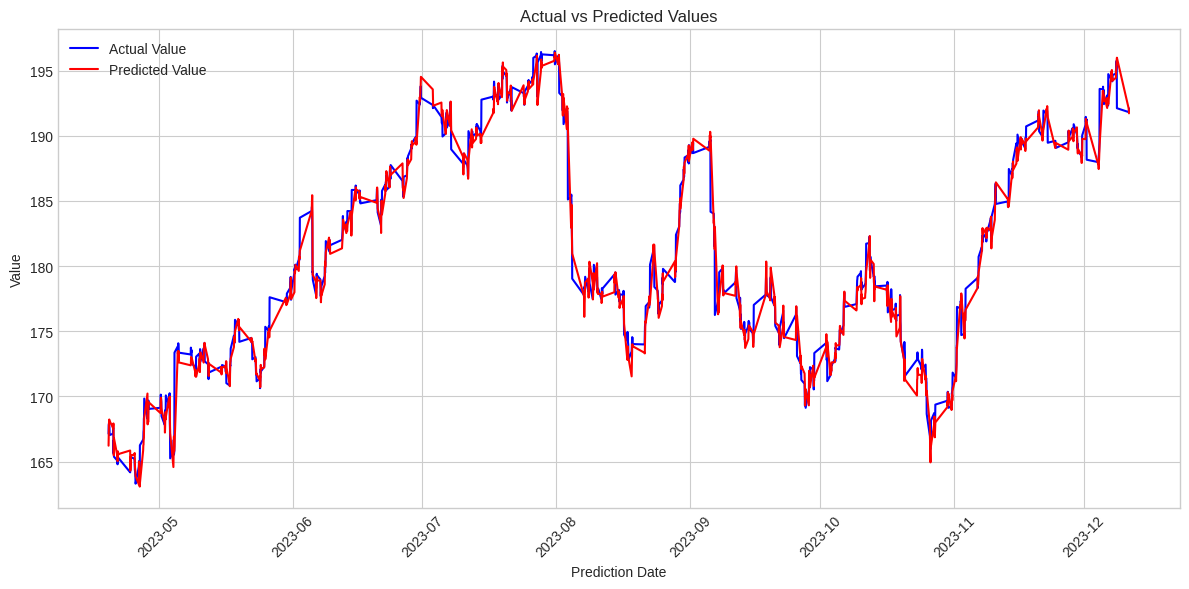

In [101]:
import matplotlib.pyplot as plt

# Extract the first predicted and first actual values along with the prediction dates
prediction_dates = results_df['prediction_date']
first_predicted_values = [pred[0] for pred in results_df['predicted_values']]
first_actual_values = [actual[0] for actual in results_df['actual_values']]

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.plot(prediction_dates, first_actual_values, label='Actual Value', color='blue', )

# Plot the predicted values
plt.plot(prediction_dates, first_predicted_values, label='Predicted Value', color='red',)

# Adding title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Prediction Date')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [121]:
results_df['first_predicted_value'] = results_df['predicted_values'].apply(lambda x: x[0][0])
results_df['first_actual_value'] = results_df['actual_values'].apply(lambda x: x[0][0])

# Create a new DataFrame with the necessary columns
context_results_df = pd.DataFrame({
    'y_actual': results_df['first_actual_value'],
    'raw_forecast': results_df['first_predicted_value'],
    'prediction_date': results_df['prediction_date']
})
context_results_df

,y_actual,raw_forecast,prediction_date
0,167.142303,166.224640,2023-04-19 09:30:00
1,167.815002,167.060669,2023-04-19 10:30:00
2,167.919998,167.776413,2023-04-19 11:30:00
3,167.899994,168.187103,2023-04-19 12:30:00
4,167.770004,168.233917,2023-04-19 13:30:00
...,...,...,...
1130,195.740005,195.717896,2023-12-08 13:30:00
1131,195.720001,195.825424,2023-12-08 14:30:00
1132,192.110001,195.982117,2023-12-08 15:30:00
1133,191.809998,192.049026,2023-12-11 09:30:00


In [128]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score


# Define the calculation functions (same as before)
def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, context_results_df):
    # Use the provided DataFrame directly
    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # Compile the results into a DataFrame
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# Calculate the results for the provided context_results_df
final_result_df = calculate_results_for_context_len(context_length, context_results_df)
print(final_result_df)


   context_len      mse  accuracy  direction_accuracy  \
0          512  0.86248  0.474427            0.528219   

   actual_direction_accuracy  direction_profit    profit  
0                    0.47619         17.594905 -4.927575  


In [125]:
def calculate_buy_and_hold_profit(context_results_df, initial_capital=100):
    """
    Calculate the profit from a buy-and-hold strategy.

    Args:
    - context_results_df (DataFrame): DataFrame containing actual prices.
    - initial_capital (float): The starting amount of money.

    Returns:
    - float: The profit from a buy-and-hold strategy.
    """
    # Buy at the first available price
    first_price = context_results_df['y_actual'].iloc[0]

    # Sell at the last available price
    last_price = context_results_df['y_actual'].iloc[-1]

    # Calculate the number of shares bought initially
    shares = initial_capital / first_price

    # Final capital after selling all shares at the last price
    final_capital = shares * last_price

    # Profit is the final capital minus the initial capital
    profit = final_capital - initial_capital

    return profit

# Assuming `context_results_df` is already prepared as in the previous code
buy_and_hold_profit = calculate_buy_and_hold_profit(context_results_df)
print(f"Buy and Hold Profit: {buy_and_hold_profit}")


Buy and Hold Profit: 14.932008306129774
